In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import gc
import glob
import torch
import utils
from scipy.special import erf
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score,
                             mutual_info_score)
from sklearn.feature_selection import mutual_info_regression, r_regression
from scipy.stats import entropy
import utils

In [2]:
model_type = 'swmag'
shap_dir = 'outputs/shap_values'
scaler_dir = 'outputs/scalers'
results_dir = 'outputs/rsd'
VERSION = 'swmag_v6-1'
shap_files = glob.glob(f'{shap_dir}/*{VERSION}*.pkl')
scaler_files = glob.glob(f'{scaler_dir}/*{VERSION}.pkl')
results_files = glob.glob(f'{scaler_dir}/*{VERSION}.feather')
with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

list_of_oversampled_regions = ['GRL-1', 'GRL-2', 'SVLB', 'JPN-0']

In [3]:
results = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		results[key] = {}
		if key in list_of_oversampled_regions:
			results[key]['swmag_results'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_v6-oversampling.feather')
			results[key]['twins_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_v_maxpooling_oversampling.feather')
		else:
			results[key]['swmag_results'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_v6-1.feather')
			results[key]['twins_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_v_maxpooling.feather')
		results[key]['mean_lat'] = utils.getting_mean_lat(region['stations'])

Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
Loading station GHB....
Loading station FHB....
Loading station NAQ....
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
Loading station MAS....
Loading station NOR....
Loading station 

In [4]:
swmag_auc, maxpool_auc, swmag_roc, maxpool_roc, mean_lat = [], [], [], [], []
for key in results.keys():

	roc = roc_curve(y_true=results[key]['swmag_results']['actual'], y_score=results[key]['swmag_results']['predicted_mean'])
	swmag_roc.append(auc(roc[0], roc[1]))
	roc = roc_curve(y_true=results[key]['twins_results']['actual'], y_score=results[key]['twins_results']['predicted_mean'])
	maxpool_roc.append(auc(roc[0], roc[1]))
	prec, rec, __ = precision_recall_curve(y_true=results[key]['swmag_results']['actual'], probas_pred=results[key]['swmag_results']['predicted_mean'])
	swmag_auc.append(auc(rec, prec))
	prec, rec, __ = precision_recall_curve(y_true=results[key]['twins_results']['actual'], probas_pred=results[key]['twins_results']['predicted_mean'])
	maxpool_auc.append(auc(rec, prec))
	mean_lat.append(results[key]['mean_lat'])

In [5]:
swmag_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'swmag_auc':swmag_auc, 'swmag_roc':swmag_roc})
maxpool_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'twins_auc':maxpool_auc, 'twins_roc':maxpool_roc})

swmag_plot_df.sort_values(by='mean_lat', inplace=True)
maxpool_plot_df.sort_values(by='mean_lat', inplace=True)

Region: GRL-3
SWMAG: 	F1: 0.7629	AUC: 0.8457
TWIN: 	F1: 0.7602	AUC: 0.8457
Region: FSC-6
SWMAG: 	F1: 0.7379	AUC: 0.8232
TWIN: 	F1: 0.7405	AUC: 0.8276
Region: ALSK
SWMAG: 	F1: 0.8271	AUC: 0.8894
TWIN: 	F1: 0.8314	AUC: 0.8949
Region: CAN-2
SWMAG: 	F1: 0.8857	AUC: 0.9397
TWIN: 	F1: 0.8866	AUC: 0.941
Region: CEU-1
SWMAG: 	F1: 0.7098	AUC: 0.7991
TWIN: 	F1: 0.7134	AUC: 0.7986
Region: JPN-1
SWMAG: 	F1: 0.4969	AUC: 0.5213
TWIN: 	F1: 0.4879	AUC: 0.4848


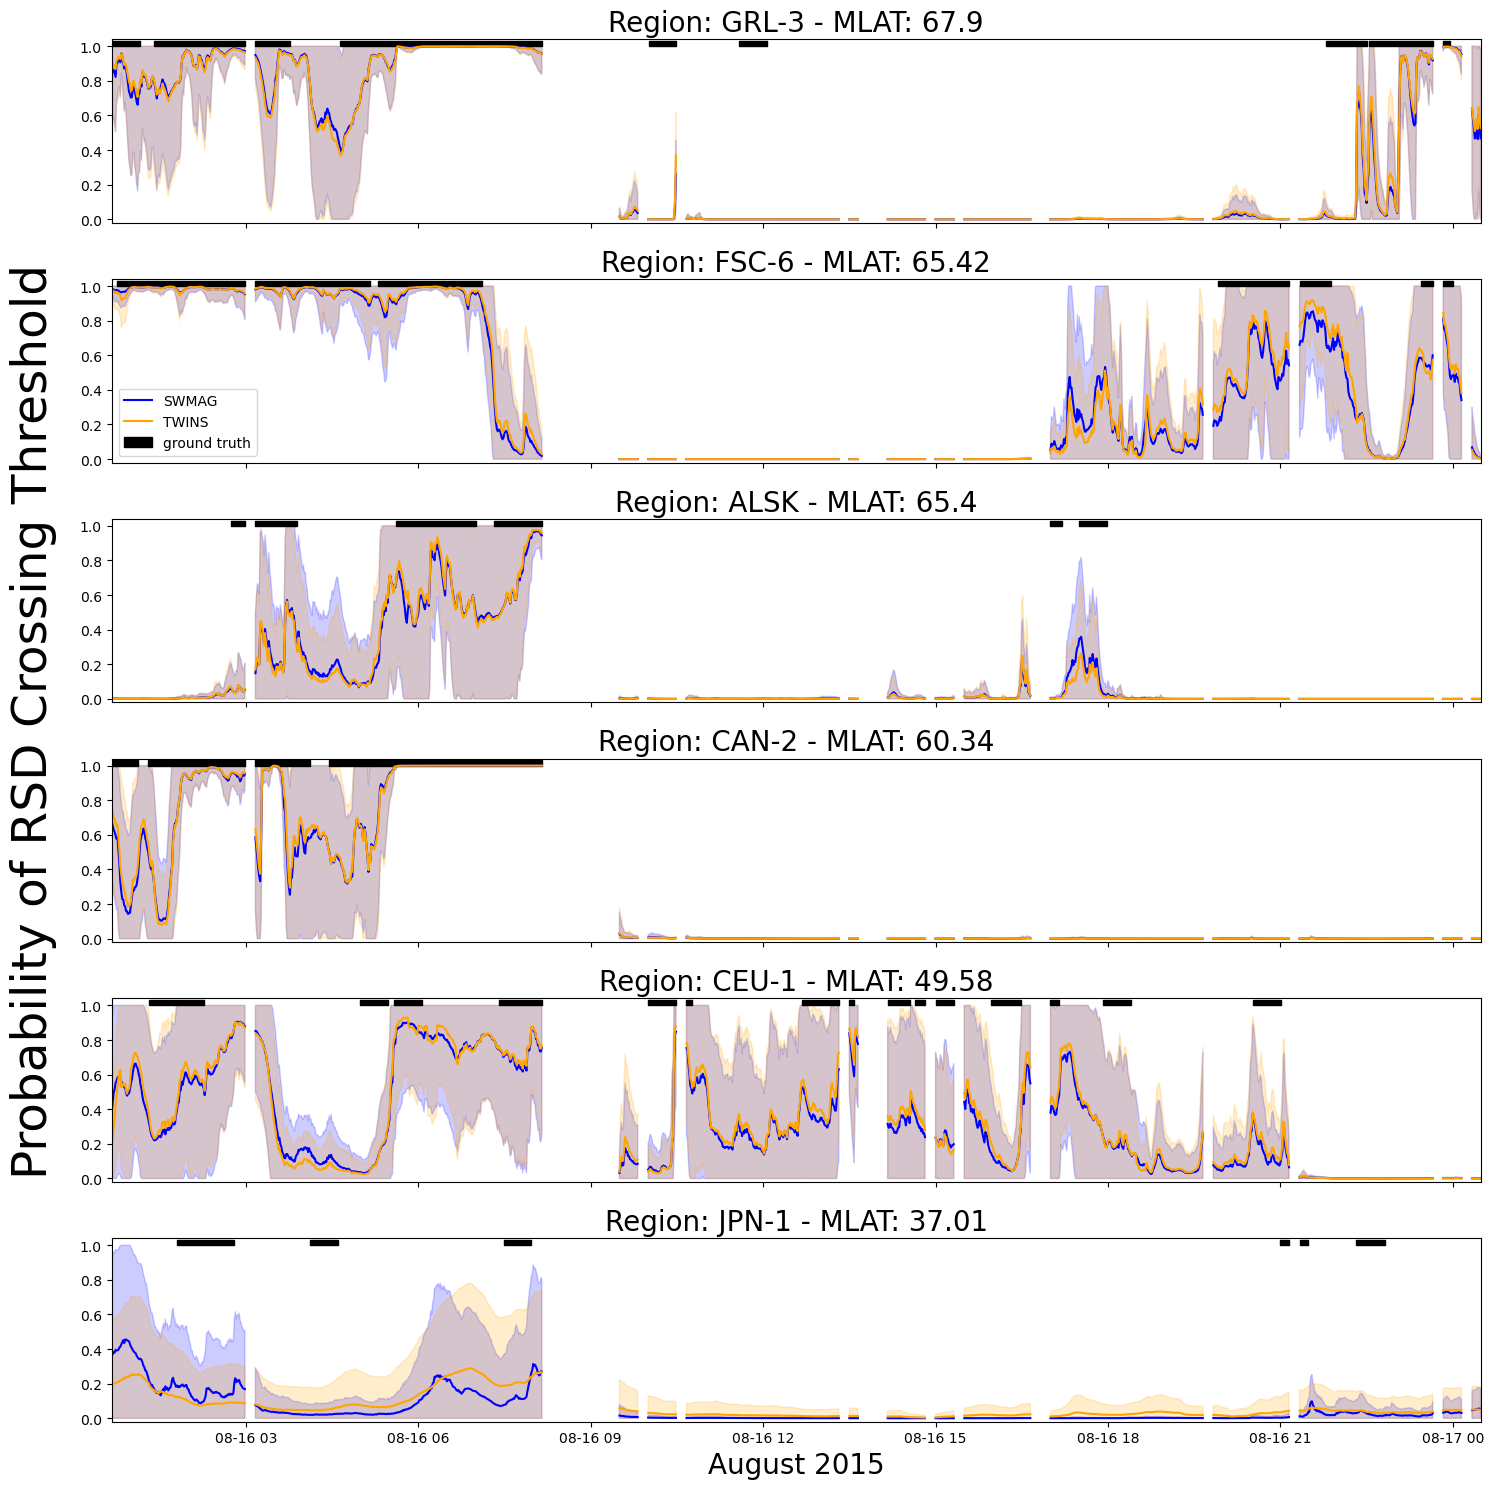

In [8]:
selected_region = 'FSC-6'

def preparing_results_plotting(region, start_date, end_date):

	list_oversampled = ['JPN-0', 'GRL-1', 'GRL-2', 'SVLB']
	if region in list_oversampled:
		swmag_results = pd.read_feather(f'outputs/rsd/non_twins_modeling_region_{region}_version_swmag_v6-oversampling.feather')
		twins_results = pd.read_feather(f'outputs/rsd/twins_modeling_region_{region}_version_twins_v_maxpooling_oversampling.feather')
	else:
		swmag_results = pd.read_feather(f'outputs/rsd/non_twins_modeling_region_{region}_version_swmag_v6-1.feather')
		twins_results = pd.read_feather(f'outputs/rsd/twins_modeling_region_{region}_version_twins_v_maxpooling.feather')

	swmag_results.set_index('dates', inplace=True)
	twins_results.set_index('dates', inplace=True)

	print(f'Region: {sel_reg}')
	prec, rec, __ = precision_recall_curve(y_true=swmag_results['actual'], probas_pred=swmag_results['predicted_mean'])
	f1 = 2 * (prec * rec) / (prec + rec)
	area = auc(rec, prec)
	# MI = mutual_info_score(swmag_results['actual'], swmag_results['predicted_mean'])
	print(f'SWMAG: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}')

	prec, rec, __ = precision_recall_curve(y_true=twins_results['actual'], probas_pred=twins_results['predicted_mean'])
	f1 = 2 * (prec * rec) / (prec + rec)
	area = auc(rec, prec)
	# MI = mutual_info_score(twins_results['actual'], twins_results['predicted_mean'])
	print(f'TWIN: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}')

	# start_date = '2012-03-06 00:00:00'
	# end_date = '2012-03-10 12:00:00'

	plotting_range = pd.date_range(start_date, end_date, freq='min')
	plotting_df = pd.DataFrame(index=plotting_range)
	plotting_df = plotting_df.join(swmag_results['actual'], how='left')
	plotting_df = plotting_df.join(swmag_results['predicted_mean'], how='left')
	plotting_df = plotting_df.join(swmag_results['predicted_std'], how='left')
	plotting_df = plotting_df.join(twins_results['predicted_mean'], how='left', rsuffix='_twins')
	plotting_df = plotting_df.join(twins_results['predicted_std'], how='left', rsuffix='_twins')
	plotting_df['swmag_fill_bottom'] = plotting_df['predicted_mean'] - plotting_df['predicted_std']
	plotting_df['swmag_fill_top'] = plotting_df['predicted_mean'] + plotting_df['predicted_std']
	plotting_df['twins_fill_bottom'] = plotting_df['predicted_mean_twins'] - plotting_df['predicted_std_twins']
	plotting_df['twins_fill_top'] = plotting_df['predicted_mean_twins'] + plotting_df['predicted_std_twins']
	plotting_df.clip(lower=0, upper=1, inplace=True)
	plotting_df['bottom'] = plotting_df['actual']*1.00
	plotting_df['top'] = plotting_df['actual']*1.03

	return plotting_df

start_date = '2015-08-10 00:00:00'
end_date = '2015-08-20 12:00:00'
selected_regions = ['GRL-3', 'FSC-6', 'ALSK', 'CAN-2', 'CEU-1', 'JPN-1']

fig, axes = plt.subplots(len(selected_regions), 1, figsize=(15, 15), sharex=True)

for i, sel_reg in enumerate(selected_regions):
	plotting_df = preparing_results_plotting(sel_reg, start_date, end_date)
	# creates an array from the y_bar dataframe
	z1=np.array(plotting_df['bottom'])
	# creates another array. These two arrays are compared to create the bar at the top of the plots.
	z2=np.array(plotting_df['top'])

	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean'], color='blue', label='SWMAG')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'swmag_fill_bottom'], plotting_df.loc[start_date:end_date, 'swmag_fill_top'], color='blue', alpha=0.2)
	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean_twins'], color='orange', label='TWINS')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'twins_fill_bottom'], plotting_df.loc[start_date:end_date, 'twins_fill_top'], color='orange', alpha=0.2)
	axes[i].fill_between(plotting_df.index, plotting_df['bottom'], plotting_df['top'], where=z2>z1, alpha=1, label='ground truth', color='black')
	mlat = str(round(results[sel_reg]['mean_lat'], 2))
	axes[i].set_title(f'Region: {sel_reg} - MLAT: {mlat}', fontsize=20)
	plt.margins(x=0, y=0)
	axes[i].set_ylim(-0.02,1.04)

axes[1].legend(loc='lower left')
axes[(len(selected_regions)-1)//2].set_ylabel('Probability of RSD Crossing Threshold', fontsize=35)
axes[(len(selected_regions)-1)//2].yaxis.set_label_coords(-0.04,-0.1)
axes[len(selected_regions)-1].set_xlabel('August 2015', fontsize=20)
plt.subplots_adjust(wspace=1, hspace=1)
plt.tight_layout()

plt.savefig(f'plots/GEM_2024_plots/regions_example.png')


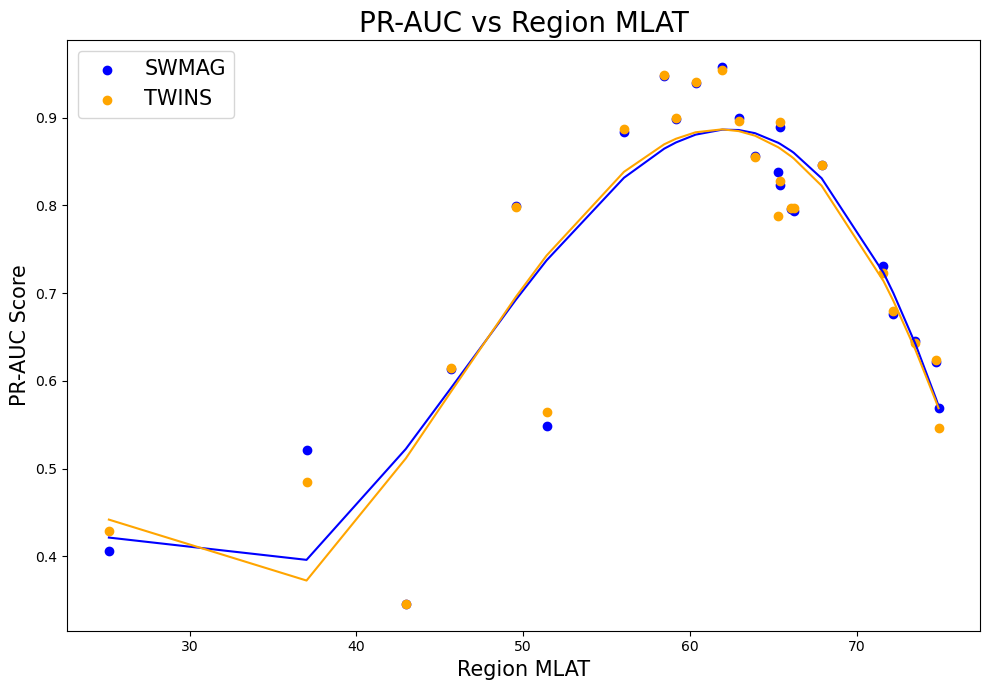

In [7]:
fig, axes = plt.subplots(1,1,figsize=(10,7))
axes.scatter(swmag_plot_df['mean_lat'], swmag_plot_df['swmag_auc'], label='SWMAG', color='blue')
axes.scatter(maxpool_plot_df['mean_lat'], maxpool_plot_df['twins_auc'], label='TWINS', color='orange')

swmag_z = np.polyfit(swmag_plot_df['mean_lat'], swmag_plot_df['swmag_auc'], 4)
swmag_p = np.poly1d(swmag_z)
maxpool_z = np.polyfit(maxpool_plot_df['mean_lat'], maxpool_plot_df['twins_auc'], 4)
maxpool_p = np.poly1d(maxpool_z)

axes.plot(swmag_plot_df['mean_lat'], swmag_p(swmag_plot_df['mean_lat']), color='blue')
axes.plot(maxpool_plot_df['mean_lat'], maxpool_p(maxpool_plot_df['mean_lat']), color='orange')

axes.set_xlabel('Region MLAT', fontsize=15)
axes.set_ylabel('PR-AUC Score', fontsize=15)
axes.set_title('PR-AUC vs Region MLAT', fontsize=20)
axes.legend(loc='upper left', fontsize=15)
plt.tight_layout()
plt.savefig(f'plots/GEM_2024_plots/pr-auc_vs_region_mlat_swmag_maxpool.png')

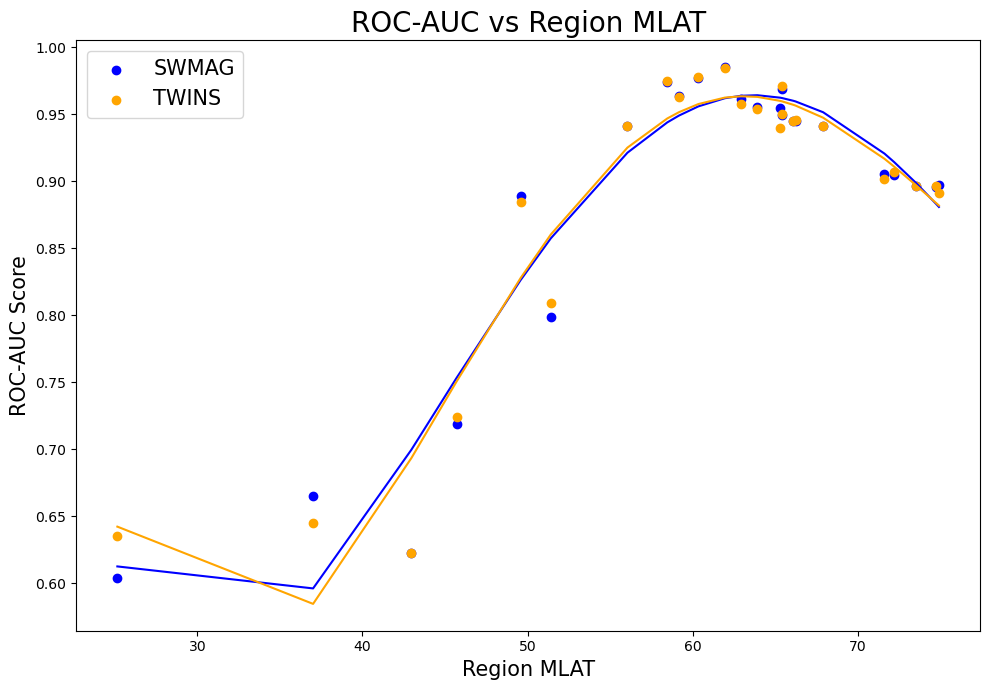

In [9]:
fig, axes = plt.subplots(1,1,figsize=(10,7))
axes.scatter(swmag_plot_df['mean_lat'], swmag_plot_df['swmag_roc'], label='SWMAG', color='blue')
axes.scatter(maxpool_plot_df['mean_lat'], maxpool_plot_df['twins_roc'], label='TWINS', color='orange')

swmag_z = np.polyfit(swmag_plot_df['mean_lat'], swmag_plot_df['swmag_roc'], 4)
swmag_p = np.poly1d(swmag_z)
maxpool_z = np.polyfit(maxpool_plot_df['mean_lat'], maxpool_plot_df['twins_roc'], 4)
maxpool_p = np.poly1d(maxpool_z)

axes.plot(swmag_plot_df['mean_lat'], swmag_p(swmag_plot_df['mean_lat']), color='blue')
axes.plot(maxpool_plot_df['mean_lat'], maxpool_p(maxpool_plot_df['mean_lat']), color='orange')

axes.set_xlabel('Region MLAT', fontsize=15)
axes.set_ylabel('ROC-AUC Score', fontsize=15)
axes.set_title('ROC-AUC vs Region MLAT', fontsize=20)
axes.legend(loc='upper left', fontsize=15)
plt.tight_layout()	
plt.savefig(f'plots/roc-auc_vs_region_mlat_swmag_maxpool.png')

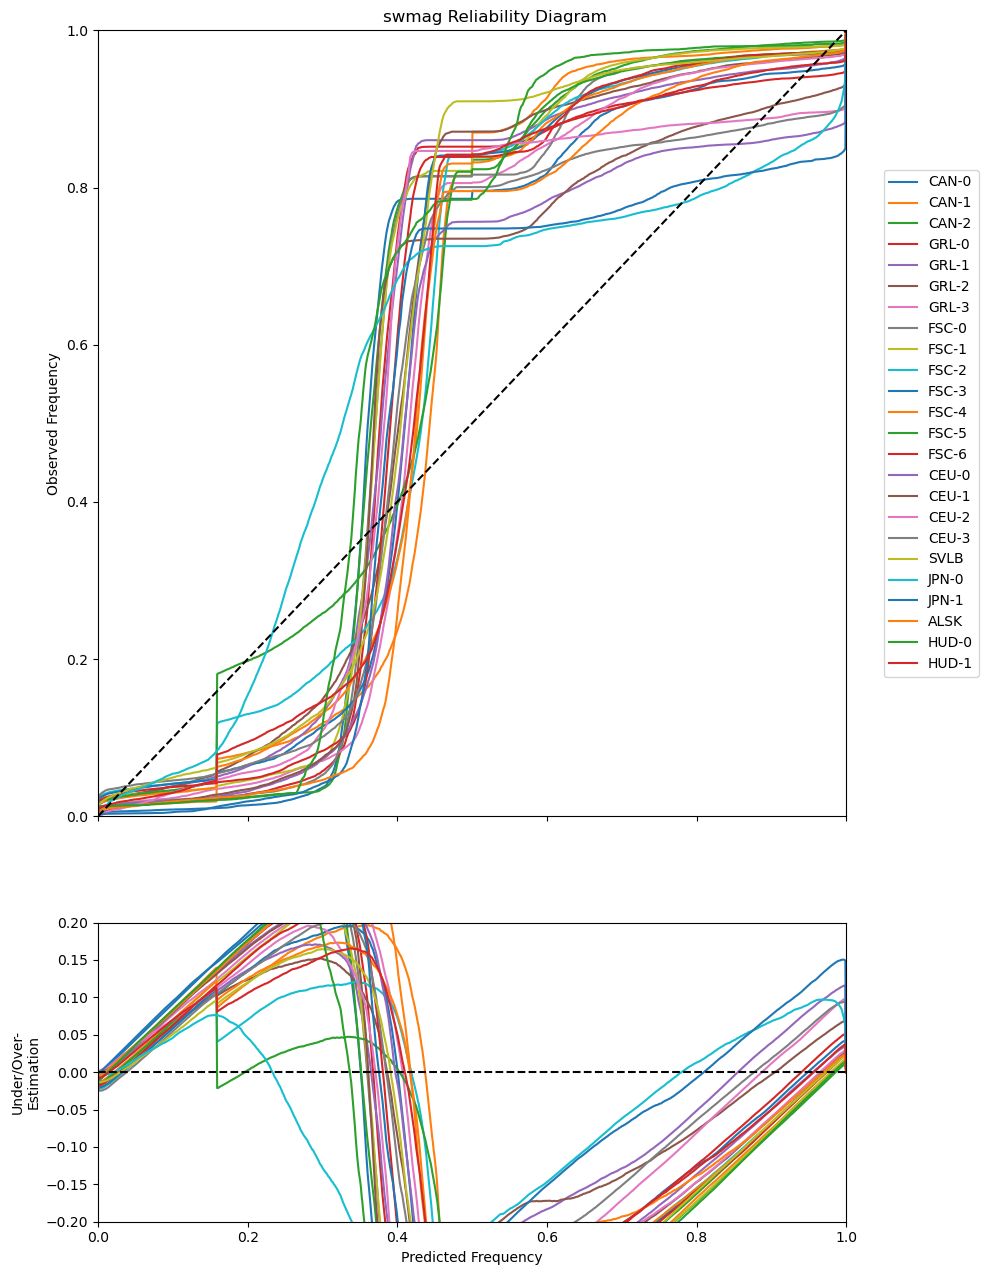

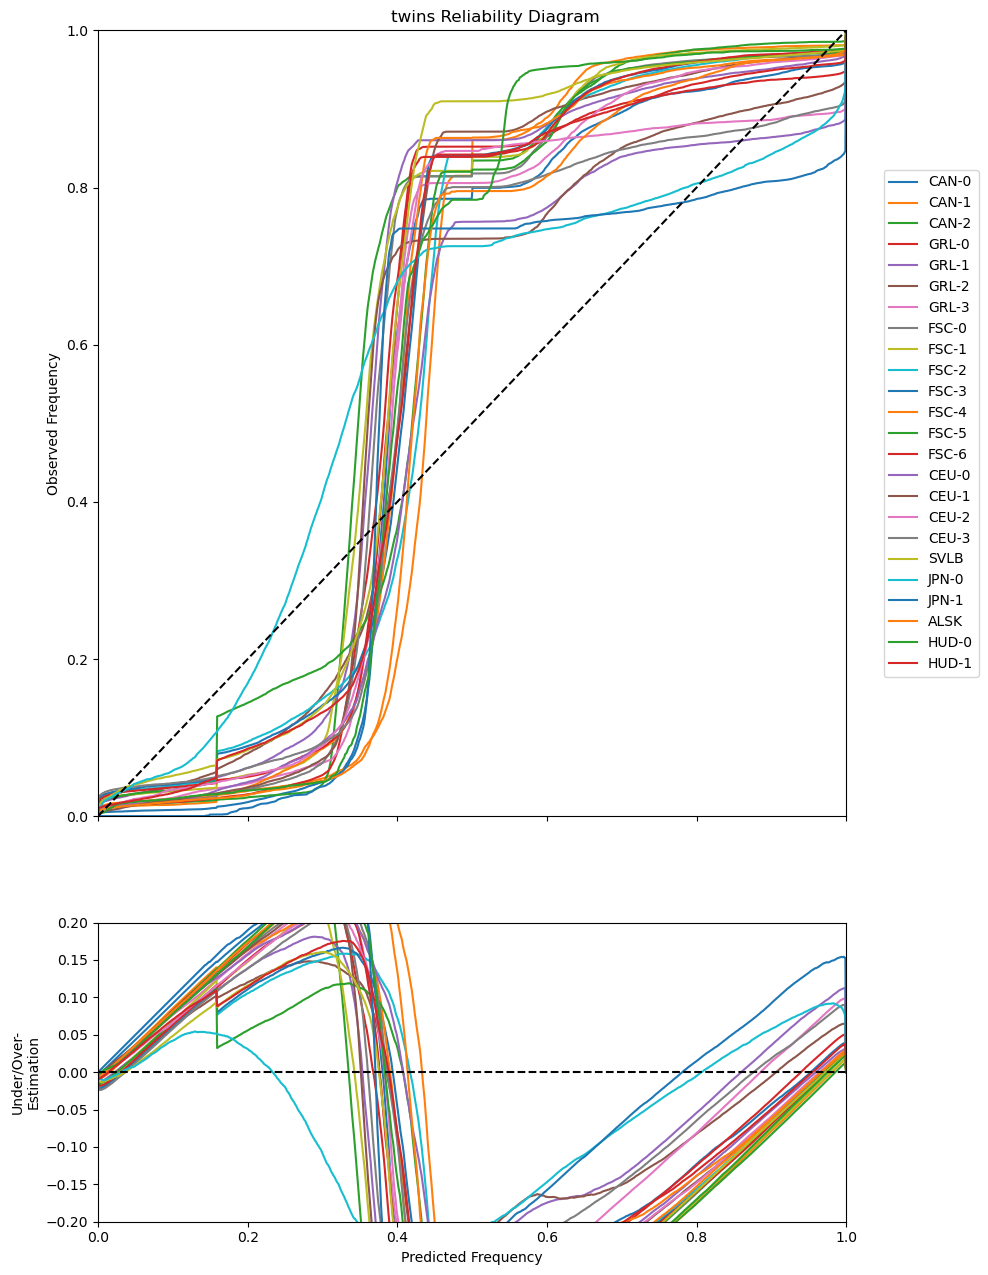

In [11]:
def plotting_continuious_reliability_diagram(results, model):

	''' Function that plots the reliability diagram for the predictions.'''

	x = np.linspace(0, 1, 1000)

	fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10,15))

	for region in results.keys():
		predictions = results[region][f'{model}_results'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
		actual = predictions['actual']
		predicted_mean = predictions['predicted_mean']
		predicted_std = predictions['predicted_std'].abs()

		standard_error = (actual - predicted_mean)/(np.sqrt(2) * predicted_std).to_numpy() #Standard error for each parameter
		cumulative_dist = np.zeros((len(x), 1)) #Cumulative distribution for each parameter
		for i in standard_error.index:
			cumulative_dist[:,0] += (1/len(standard_error)) * np.heaviside(x - 0.5*(erf(standard_error.loc[i])+1) , 1) #Calculate the cumulative distribution for each parameter

		ax[0].plot(x, cumulative_dist[:,0], label=region)
		ax[1].plot(x, x - cumulative_dist[:,0], label=region)

	#Place legend to the right middle of the figure
	ax[0].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
	ax[0].plot(x, x, linestyle = '--', color = 'k')
	ax[0].set_ylabel('Observed Frequency')
	ax[0].set_xlim(0,1)
	ax[0].set_ylim(0,1)
	fig.suptitle(f'{model} Reliability Diagram')

	ax[1].plot(x, np.zeros(len(x)), linestyle = '--', color = 'k')
	ax[1].set_ylim(-0.2,0.2)
	ax[1].set_xlabel('Predicted Frequency')
	ax[1].set_ylabel('Under/Over-\nEstimation')
	ax[1].set_aspect('equal')
	plt.subplots_adjust(hspace = -0.20)

	plt.tight_layout()
	plt.savefig(f'plots/{model}_reliability_diagram.png', bbox_inches='tight')

plotting_continuious_reliability_diagram(results, model='swmag')
plotting_continuious_reliability_diagram(results, model='twins')